In [42]:
import uproot4
from coffea.processor import LazyDataFrame

import numpy as np
import pandas as pd



In [43]:
f = uproot4.open('/hadoop/cms/store/user/dspitzba/WHhadronic/signal/GenModel_TChiWH_1000_1.root')

In [44]:
runs_df = LazyDataFrame(f["Runs"], flatten=False)
events_df = LazyDataFrame(f["Events"], flatten=False)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


# Central signal simulation and x-secs

```
/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM
```

The central scan is completely inclusive in terms of W and H decays.


In [4]:
import os
def dasWrapper(DASname, query='file'):
    sampleName = DASname.rstrip('/')

    dbs='dasgoclient -query="%s dataset=%s"'%(query, sampleName)
    dbsOut = os.popen(dbs).readlines()
    dbsOut = [ l.replace('\n','') for l in dbsOut ]
    return dbsOut

WH_files = dasWrapper('/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM', query='file')
WZ_files = dasWrapper('/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM', query='file')

In [5]:
if WH_files[0].startswith('/store/'):
    WH_files = [ 'root://xrootd.t2.ucsd.edu:2040/' + f for f in WH_files]
if WZ_files[0].startswith('/store/'):
    WZ_files = [ 'root://xrootd.t2.ucsd.edu:2040/' + f for f in WZ_files]

In [6]:
def getSumWeight(fin, model="TChiWH"):
    try:
        f = uproot4.open(fin)
    except:
        print ("Couldn't open file: %s"%fin)
        return {}
    events_df = LazyDataFrame(f["Events"], flatten=False)
    runs_df = LazyDataFrame(f["Runs"], flatten=False)
    included_models = [k.replace('GenModel_','') for k in events_df.keys() if k.count('GenModel_%s'%model)]
    
    res = {model: {
        'EventCount': runs_df['genEventCount_%s'%model].sum(),
        'Sumw': runs_df['genEventSumw_%s'%model].sum(),
        'Sumw2': runs_df['genEventSumw2_%s'%model].sum()} for model in included_models }
    
    return res

In [7]:
# test a file that's broken or unavailable
getSumWeight('root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/5DF37370-E3D9-F947-A31B-1FD1BA5B51EA.root')

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/5DF37370-E3D9-F947-A31B-1FD1BA5B51EA.root


{}

In [8]:
# preliminary storage of the weights etc - should be replaced with something more meaningful
import pickle

with open('../data/WH_xsec.txt', 'r') as f:
    lines = f.readlines()
    
xsec = {}
for line in lines:
    l = line.replace('\n','').split()
    xsec[int(l[0])] = {'central': float(l[1]), 'sigma': float(l[2])}

In [85]:
# This is really slow, but if we do it right, we only have to do this once in our life time
# We should also make a list of files that are ok
# --> single files can be corrupt, and we don't want them to make our life miserable.

allweights = {}
goodfiles = []

from tqdm import tqdm

def getSignalWeights(files, model='TChiWH'):
    for i in tqdm(range(len(files))):
        fin = files[i]
        res = getSumWeight(fin, model=model)
        if not res == {}:
            # if file is not readable, corrupt or empty we should skip it, otherwise add it
            goodfiles.append(fin)
        for k in res:
            try:
                # first, try to add onto existing events
                allweights[k]['EventCount'] += res[k]['EventCount']
                allweights[k]['Sumw'] += res[k]['Sumw']
                allweights[k]['Sumw2'] += res[k]['Sumw2']
            except KeyError:
                # new model point, initialize
                allweights[k] = {}
                allweights[k]['EventCount'] = res[k]['EventCount']
                allweights[k]['Sumw'] = res[k]['Sumw']
                allweights[k]['Sumw2'] = res[k]['Sumw2']
            
    signal_dict = [ {'mNLSP': int(k.split('_')[1]), 'mLSP': int(k.split('_')[2]), 'sumweight': allweights[k]['Sumw'], 'xsec': xsec[int(k.split('_')[1])]['central']} for k in allweights if  int(k.split('_')[1])%5==0 ]
    signal_df = pd.DataFrame([ {'mNLSP': int(k.split('_')[1]), 'mLSP': int(k.split('_')[2]), 'sumweight': allweights[k]['Sumw'], 'xsec': xsec[int(k.split('_')[1])]['central']} for k in allweights if  int(k.split('_')[1])%5==0 ])

    return signal_dict, goodfiles

#WH_signal_dict, WH_goodfiles = getSignalWeights(WH_files)
#
#with open('WH_signalweights.pkl', 'wb') as f:
#    pickle.dump(WH_signal_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
#    
#with open('WH_signalfiles.pkl', 'wb') as f:
#    pickle.dump(WH_goodfiles, f, protocol=pickle.HIGHEST_PROTOCOL)
    
WZ_signal_dict, WZ_goodfiles = getSignalWeights(WZ_files, model='TChiWZ')

with open('WZ_signalweights.pkl', 'wb') as f:
    pickle.dump(WZ_signal_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('WZ_signalfiles.pkl', 'wb') as f:
    pickle.dump(WZ_goodfiles, f, protocol=pickle.HIGHEST_PROTOCOL)

  2%|▏         | 3/193 [01:37<1:40:44, 31.81s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/D72A552F-310D-B140-AD72-1D41E937A0D2.root


  2%|▏         | 4/193 [02:20<1:50:47, 35.17s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/A17DC46C-2D20-704E-A2EC-DA0768ED7789.root


  3%|▎         | 5/193 [02:50<1:45:20, 33.62s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/D3B600EA-3536-054A-A27B-C567EE57AF0D.root


  3%|▎         | 6/193 [03:20<1:41:24, 32.54s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/2B8B60B6-B9A3-8D43-BCD2-6584271A8E55.root


  4%|▍         | 8/193 [04:20<1:36:40, 31.36s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/DD9614FE-439A-2548-8569-799B837FF88F.root


  5%|▌         | 10/193 [05:35<1:45:46, 34.68s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/35613CD7-CD1A-C545-94EB-083CDFAFD140.root


  7%|▋         | 13/193 [06:35<1:22:57, 27.65s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/8F0224EF-F6EE-064E-91AA-CA829791D64A.root


  8%|▊         | 15/193 [07:32<1:25:14, 28.74s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/84F832CB-ECF8-A34A-93E1-F41C067C9F5A.root


  8%|▊         | 16/193 [08:05<1:28:32, 30.02s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/C9DC8FA8-6687-5C4A-9294-3C31DE4FE93A.root


  9%|▉         | 18/193 [09:05<1:29:02, 30.53s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/009B47AD-03AE-4B4C-AF81-8F023E3F90D8.root


 11%|█         | 21/193 [10:50<1:36:53, 33.80s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/9CBCAE38-EC04-3C41-AA81-DBF1132271A3.root


 12%|█▏        | 24/193 [11:35<1:06:55, 23.76s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/01107E5E-7BB6-C345-81EA-3050A3E50B39.root


 13%|█▎        | 26/193 [12:17<1:04:22, 23.13s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/EB610946-1C28-9A45-B8A9-020751B79028.root


 14%|█▍        | 27/193 [12:50<1:12:11, 26.09s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/09929001-8FCB-1F4E-BCCD-5619C2557FF0.root


 15%|█▌        | 29/193 [13:32<1:07:10, 24.58s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/120000/D75A7F65-32F3-554D-AB92-C6E4596D4290.root


 16%|█▌        | 30/193 [14:05<1:13:38, 27.10s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/A5AB5C45-A7CD-AB4C-807B-2034411BE105.root


 17%|█▋        | 33/193 [15:35<1:18:53, 29.58s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/2E893D50-6B20-E64C-8576-2C4A4497358F.root


 18%|█▊        | 34/193 [16:05<1:18:43, 29.71s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/97811C32-133F-174A-9E5E-CA5D92562DB9.root


 19%|█▊        | 36/193 [17:17<1:27:15, 33.35s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/5B12E6E9-D71A-0042-9573-2077B6615AC1.root


 19%|█▉        | 37/193 [17:50<1:26:25, 33.24s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/D40B3D53-AAD6-D141-BFFC-16416506117A.root


 21%|██        | 40/193 [19:35<1:27:51, 34.45s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/242276DD-5515-314D-A110-4A0E7AC84BDC.root


 22%|██▏       | 43/193 [21:05<1:20:46, 32.31s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/C1C9228A-373D-0748-82D4-8D86ACEEBEDB.root


 24%|██▍       | 46/193 [22:20<1:11:34, 29.21s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/66820886-69F4-5549-823A-3972BF8BA336.root


 25%|██▍       | 48/193 [23:23<1:14:15, 30.72s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/EC9827EE-10C7-C942-BCED-F3621BAD6883.root


 25%|██▌       | 49/193 [24:05<1:21:51, 34.11s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/62387B64-EF58-5D46-97B4-0344EFD2F6A9.root


 26%|██▋       | 51/193 [24:50<1:11:17, 30.12s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/D63FB2D3-F06F-3E46-B5A6-7E1B450C28F1.root


 27%|██▋       | 52/193 [25:20<1:10:42, 30.09s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/A11BEE8F-2E34-AC4B-8052-1ADA1ABEAACF.root


 28%|██▊       | 55/193 [27:05<1:17:09, 33.54s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/D6F238DF-699D-9542-96D8-18ECB2B0149E.root


 30%|██▉       | 57/193 [28:05<1:12:41, 32.07s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/AF9D4F09-5A44-5249-B082-3B8E1176058A.root


 30%|███       | 58/193 [28:35<1:10:45, 31.45s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/33E6259F-3185-DF48-B754-89BBF8DBA20F.root


 32%|███▏      | 61/193 [30:05<1:07:42, 30.78s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/F6AF8FBC-1836-5F46-AA65-74B0DEF24464.root


 33%|███▎      | 63/193 [31:05<1:07:11, 31.01s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/AECDED8A-31B6-EF46-BEB3-6EB24E769B90.root


 34%|███▍      | 66/193 [32:35<1:06:12, 31.28s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/EFF946E8-A2FC-F84E-9F02-C5204F0FA1A8.root


 35%|███▌      | 68/193 [33:12<54:42, 26.26s/it]  

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/9C4DEC59-15DC-294D-9E43-82EA346E44A8.root


 36%|███▌      | 69/193 [33:50<1:01:33, 29.78s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/68F481A1-ACF8-884E-ACDC-522234A5349D.root


 37%|███▋      | 71/193 [34:35<56:02, 27.56s/it]  

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/E255D708-DEE2-4043-8562-956F606AC342.root


 37%|███▋      | 72/193 [35:05<57:03, 28.29s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/667028FD-CD67-FD4A-B301-4254917F0FC3.root


 38%|███▊      | 74/193 [35:50<53:56, 27.20s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/E206B491-7FD5-A84C-AEFE-480D4B62A979.root


 39%|███▉      | 75/193 [36:20<55:08, 28.04s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/81E4C351-13B6-2545-B3D8-1AB7076BE29A.root


 40%|███▉      | 77/193 [37:20<57:03, 29.51s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/E4A16E88-7A6D-B044-A933-28FBF303467A.root


 41%|████      | 79/193 [38:20<57:39, 30.35s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/E28038C8-1574-CA46-8462-134A20317E3F.root


 41%|████▏     | 80/193 [38:50<56:57, 30.25s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/86A4F7F6-2B99-1D44-A5EB-2388E81BD9C7.root


 43%|████▎     | 83/193 [40:35<1:01:52, 33.75s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/DE467128-4C7D-CA42-B8FD-9349875A5F39.root


 44%|████▎     | 84/193 [41:11<1:02:32, 34.43s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/F7EDD9ED-D192-CE46-ABAB-E04B65D21F1D.root


 44%|████▍     | 85/193 [41:50<1:04:26, 35.80s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/5E5E0ECB-8932-6C4B-A448-0C0A753CE281.root


 45%|████▌     | 87/193 [42:56<1:02:25, 35.33s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/AE0A1F35-7B50-2242-AAEB-A077DDCC255E.root


 47%|████▋     | 90/193 [44:50<1:04:56, 37.83s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/ED2EAE45-0910-044F-9A37-D2029F502F18.root


 48%|████▊     | 92/193 [45:26<48:30, 28.82s/it]  

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/FFCCC6D5-E715-4147-9E5D-E3CFF2FA1D35.root


 48%|████▊     | 93/193 [46:05<53:07, 31.88s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/4946FDCE-AD6F-2040-B43B-F447CBAEE53C.root


 49%|████▉     | 95/193 [46:56<48:50, 29.90s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/5806359F-86DB-8E49-A641-476DAA935B7F.root


 50%|████▉     | 96/193 [47:35<52:45, 32.63s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/A9CB884B-A33D-D849-80D2-F9F369863DE4.root


 51%|█████▏    | 99/193 [48:35<43:12, 27.58s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/6AFF2EAC-B26B-4F4C-9649-BB6EBEE75B92.root


 52%|█████▏    | 100/193 [49:05<43:52, 28.31s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/6E0712FE-6EBF-AE4E-90B3-3903C5E85904.root


 53%|█████▎    | 102/193 [50:05<45:12, 29.81s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/AFCCFEA4-15B4-D943-9D98-F7D418289CFA.root


 53%|█████▎    | 103/193 [50:35<44:48, 29.87s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/CDC1457E-BF4B-B74E-A753-F42A4038026C.root


 54%|█████▍    | 105/193 [51:41<46:12, 31.51s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/BDB8C134-15F3-6B47-9BB3-03B73EBCF15B.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/D21B752D-3AEA-FB43-A683-904BC77BF845.root


 56%|█████▌    | 108/193 [52:41<40:45, 28.77s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/5B635A4E-5678-7744-A050-6D1D58C449C7.root


 56%|█████▋    | 109/193 [53:20<44:34, 31.84s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/6A2FE8D3-0DCF-404C-90AA-1D5C823848E0.root


 58%|█████▊    | 112/193 [54:03<27:59, 20.74s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/CEE1EDA0-12B2-4947-A58C-C22F024DB80A.root


 59%|█████▉    | 114/193 [54:41<28:00, 21.27s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/B18A223C-B242-864C-BD1B-B6ACD9BB6B3B.root


 60%|█████▉    | 115/193 [54:43<20:18, 15.62s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/F6FD719C-FAB6-7C47-AE6A-F469C769582A.root


 60%|██████    | 116/193 [55:09<23:54, 18.63s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/87BF1D38-461C-FE47-8707-5F34813D4871.root


 62%|██████▏   | 119/193 [56:11<28:38, 23.23s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/F58844CC-AE45-A146-83E4-8DCBEB47E8AF.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/003DA1BE-D4DF-2D4D-B8F0-C33478A9BBA8.root


 63%|██████▎   | 122/193 [56:21<15:58, 13.49s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/CE8061B7-708E-AC48-A16A-5AC11B133513.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/608C5376-2FDA-AA42-A61B-1CBBCCC84B36.root


 65%|██████▍   | 125/193 [56:53<13:13, 11.68s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/C7B0ED4A-8E93-F444-ABD8-CB24AA14E949.root


 66%|██████▋   | 128/193 [57:41<20:25, 18.86s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/A871CCE1-1513-544D-831E-3497D43A1A5F.root


 67%|██████▋   | 129/193 [58:04<21:19, 19.99s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/67007541-71C5-8040-B186-9F7A579C8E1C.root


 68%|██████▊   | 131/193 [58:21<14:48, 14.32s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/390C9DF0-3863-CF4E-A4C0-D1BF393D9830.root


 69%|██████▉   | 134/193 [59:15<18:14, 18.55s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/1B268CC6-F4C2-9A48-856E-E3F2B25E5B51.root


 70%|███████   | 136/193 [59:24<13:37, 14.33s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/120000/6A2A0391-79F8-5E46-A60F-86FFB6DD6A76.root


 72%|███████▏  | 139/193 [59:54<14:14, 15.83s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/A12B0DFE-AAC7-A046-AE1B-84CA3F83A955.root


 74%|███████▍  | 143/193 [1:01:24<18:09, 21.78s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/D3D0E459-D910-794E-9E30-158866008FEF.root


 75%|███████▌  | 145/193 [1:02:20<20:07, 25.15s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/280000/946C302B-5783-3445-983F-7A27E44114EB.root


 77%|███████▋  | 148/193 [1:02:47<12:35, 16.78s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/0385EE9A-FDA7-5A46-84B7-344BFA1D696A.root


 78%|███████▊  | 150/193 [1:02:58<09:36, 13.41s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/AA6AC4B8-A453-B542-B250-B3A9604BFEF4.root


 80%|███████▉  | 154/193 [1:04:07<11:56, 18.37s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/EB8C55DD-BA88-8743-AF91-776AB323FBDB.root


 81%|████████  | 156/193 [1:04:37<09:45, 15.82s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/26597722-41DC-0A42-B84A-84E663E34AE4.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/CB1C85A6-87B7-7647-986A-D73BCB8B28E2.root


 82%|████████▏ | 159/193 [1:04:48<05:33,  9.80s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/D2F0AB22-1C80-E94D-BA93-14F2A891B38E.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/1A003CBC-F6BB-1947-ADC8-EFABEC8FE9F3.root


 84%|████████▍ | 162/193 [1:05:04<04:13,  8.16s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/CA691FAC-FAA5-5C44-9C1E-2580C954A4B1.root


 85%|████████▌ | 165/193 [1:06:00<06:34, 14.07s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/270000/25753FBC-EE47-8948-B354-36943E4981C9.root


 87%|████████▋ | 168/193 [1:06:09<03:41,  8.87s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/A260F956-B103-B945-BE9F-009368FE0CC6.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/1E126FDB-53F2-AE48-8EA8-6F6C8C7EB517.root


 89%|████████▊ | 171/193 [1:06:17<02:26,  6.64s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/23030B52-29EC-824D-9C9F-16EDD4EA816B.root


 90%|█████████ | 174/193 [1:06:39<03:00,  9.52s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/BD04453A-F04D-DF4F-82CB-386A7796AF35.root


 92%|█████████▏| 177/193 [1:07:17<03:48, 14.28s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/EAC3A0A1-F6A9-1F4F-A26B-846260D26B14.root


 93%|█████████▎| 180/193 [1:07:25<01:55,  8.89s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/B82DC574-744D-A44C-AEEE-0FAF3FD75946.root
Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/39FAB521-A8C9-C349-BD57-F0BA4C10E2E7.root


 95%|█████████▍| 183/193 [1:08:40<03:27, 20.72s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/110000/092C9BC8-0FE3-814E-A66E-64643B8DF111.root


 96%|█████████▋| 186/193 [1:08:50<01:29, 12.77s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/130000/00904E70-CCE3-A240-849D-906150D57BAB.root


 98%|█████████▊| 189/193 [1:09:30<01:00, 15.04s/it]

Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/88EC7652-DA91-184E-9A02-A90AD86AA90D.root


100%|██████████| 193/193 [1:09:38<00:00, 21.65s/it]


Couldn't open file: root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWZ_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/260000/BCD8C762-4380-A04F-890C-72A8C7B577FB.root


In [9]:
# Load the signal weights, good files, etc

with open('WH_signalweights.pkl', 'rb') as f:
    WH_signal_dict = pickle.load(f)
    
with open('WH_signalfiles.pkl', 'rb') as f:
    WH_goodfiles = pickle.load(f)

WH_signal_df = pd.DataFrame(WH_signal_dict)

In [10]:
# Load the signal weights, good files, etc

with open('WZ_signalweights.pkl', 'rb') as f:
    WZ_signal_dict = pickle.load(f)
    
with open('WZ_signalfiles.pkl', 'rb') as f:
    WZ_goodfiles = pickle.load(f)

WZ_signal_df = pd.DataFrame(WZ_signal_dict)

In [11]:
WZ_signal_df['model'] = 'WZ'
WH_signal_df['model'] = 'WH'

frames = [WZ_signal_df, WH_signal_df]
signal_df = pd.concat(frames)

In [13]:
#signal_df[signal_df['model']=='WZ']

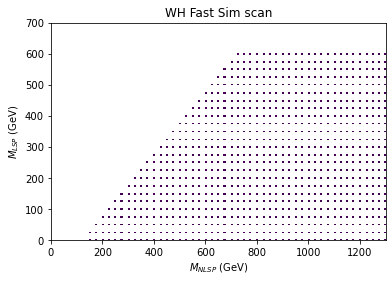

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

figure=plt.figure(1)
plt.hist2d(WH_signal_df['mNLSP'].tolist(), WH_signal_df['mLSP'].tolist(), bins=325, range=[[0, 1300], [0,700]], cmin = 1)
plt.xlabel(r'$M_{NLSP}$ (GeV)')
plt.ylabel(r'$M_{LSP}$ (GeV)')
plt.title('WH Fast Sim scan')

plt.show()

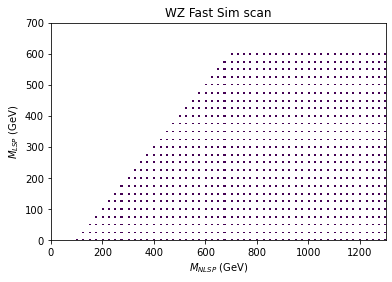

In [15]:
figure=plt.figure(1)
plt.hist2d(WZ_signal_df['mNLSP'].tolist(), WZ_signal_df['mLSP'].tolist(), bins=325, range=[[0, 1300], [0,700]], cmin = 1)
plt.xlabel(r'$M_{NLSP}$ (GeV)')
plt.ylabel(r'$M_{LSP}$ (GeV)')
plt.title('WZ Fast Sim scan')

plt.show()

In [16]:
print (len(WZ_goodfiles))

97


# Processing the scan with uproot/coffea

Try out processing a single file first


In [17]:
## root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/B78DACF7-D831-6746-ABCD-7410330E1C66.root
#scan_sample = uproot4.open('root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/100000/7E7EC298-99DC-C04C-8A87-96D513F5B52C.root')
scan_sample = uproot4.open('root://xrootd.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/SMS-TChiWH_TuneCP2_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUFall18Fast_Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/250000/B78DACF7-D831-6746-ABCD-7410330E1C66.root')

In [18]:
events_df = LazyDataFrame(scan_sample["Events"], flatten=False)

In [19]:
events_df["GenModel_TChiWH_1000_1"]

array([False, False, False, ..., False, False, False])

In [20]:
#scan_sample["Events"].show()

In [28]:

# x-secs in fb
included_models = [k for k in events_df.keys() if k.count('GenModel_TChiWH')]
mNLSP = np.zeros(len(events_df['MET_pt']))
mLSP = np.zeros(len(events_df['MET_pt']))
weight = np.zeros(len(events_df['MET_pt']))

for model in included_models:
    #print (model)
    tmp_mNLSP = int(model.split('_')[2])
    tmp_mLSP = int(model.split('_')[3])
    try:
        xsec = float(signal_df[((signal_df['mNLSP']==tmp_mNLSP) & (signal_df['mLSP']==tmp_mLSP) & (signal_df['model']=='WH') )]['xsec'])
        sumweight = float(signal_df[((signal_df['mNLSP']==tmp_mNLSP) & (signal_df['mLSP']==tmp_mLSP) & (signal_df['model']=='WH'))]['sumweight'])
    except TypeError:
        #print ("No x-sec")
        xsec = 0
        sumweight = 1
    mNLSP += events_df[model] * tmp_mNLSP
    mLSP += events_df[model] * tmp_mLSP
    weight += ( events_df['genWeight'] * events_df[model] * xsec / sumweight) #  

In [29]:
mNLSP

array([ 500.,  500.,  500., ..., 1025., 1025., 1025.])

In [30]:
mLSP

array([100., 100., 100., ..., 600., 600., 600.])

In [31]:
weight

array([5.88561001e-04, 5.88561001e-04, 5.88561001e-04, ...,
       1.41781611e-05, 1.41781611e-05, 1.41781611e-05])

In [32]:
events_df['genWeight']

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [33]:
events_df['GenModel_TChiWH_500_100']

array([ True,  True,  True, ..., False, False, False])

In [34]:
events_df['GenModel_TChiWH_1025_600']

array([False, False, False, ...,  True,  True,  True])

# Coffea processor

In [35]:
fileset = {'WH': WH_goodfiles, 'WZ': WZ_goodfiles}


In [37]:
%load_ext autoreload
%autoreload 2

from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import uproot_methods
import awkward

from klepto.archives import dir_archive

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        mNLSP_axis          = hist.Bin("mNLSP",     "mNLSP", 49, 87.5, 1312.5)
        mLSP_axis           = hist.Bin("mLSP",      "mLSP", 41, -12.5, 1012.5)
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 2000, 0, 2000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 1000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)
        higgs_axis          = hist.Bin("higgs_pt",        r"$p_{T}$ (GeV)", 2000, 0, 2000)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" : hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, pt_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, pt_axis),
            "Higgs_pt" :        hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, pt_axis),
            "Higgs_mass" :      hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, mass_axis),
            "W_mass" :          hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, mass_axis),
            "Higgs_msoftdrop" : hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, mass_axis),
            "W_msoftdrop" :     hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, mass_axis),
            "HT_AK8" :          hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, ht_axis),
            "ST_AK8" :          hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, ht_axis),
            # for signal regions we can just create a N dimensional histogram
            #"SR" :              hist.Hist("Counts", dataset_axis, mNLSP_axis, mLSP_axis, pt_axis),
            
            'WH':               processor.defaultdict_accumulator(int),
            'WZ':               processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## This is hacked in and should go somewhere else
        # x-secs in fb
        included_models = []
        included_models += [k for k in df.keys() if k.count('GenModel_TChiW')]
        #included_models += [k for k in df.keys() if k.count('GenModel_TChiWZ')]
        mNLSP = np.zeros(len(df['MET_pt']))
        mLSP = np.zeros(len(df['MET_pt']))
        weight = np.zeros(len(df['MET_pt']))

        for model in included_models:
            #print (model)
            tmp_name = model.split('_')[1].replace('TChi','')
            tmp_mNLSP = int(model.split('_')[2])
            tmp_mLSP = int(model.split('_')[3])
            #tmp_df = signal_df[signal_df['model']==tmp_name]
            try:
                xsec = float(signal_df[((signal_df['mNLSP']==tmp_mNLSP) & (signal_df['mLSP']==tmp_mLSP) & (signal_df['model']==tmp_name) )]['xsec'])
                sumweight = float(signal_df[((signal_df['mNLSP']==tmp_mNLSP) & (signal_df['mLSP']==tmp_mLSP) & (signal_df['model']==tmp_name) )]['sumweight'])
            except TypeError:
                #print ("No x-sec")
                xsec = 0
                sumweight = 1
            mNLSP += df[model] * tmp_mNLSP
            mLSP += df[model] * tmp_mLSP
            weight += ( df['genWeight'] * df[model] * xsec / sumweight) #  
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        
        ## Muons
        muon = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            miniPFRelIso_all=df['Muon_miniPFRelIso_all'].content,
            looseId =df['Muon_looseId'].content
            )
        muon = muon[(muon.pt > 10) & (abs(muon.eta) < 2.4) & (muon.looseId) & (muon.miniPFRelIso_all < 0.2)]
        #muon = Collections(df, "Muon", "tightTTH").get() # this needs a fix for DASK
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        ## Electrons
        electron = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt = df['Electron_pt'].content,
            eta = df['Electron_eta'].content,
            phi = df['Electron_phi'].content,
            mass = df['Electron_mass'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            cutBased=df['Electron_cutBased'].content
            )
        electron = electron[(electron.pt>10) & (abs(electron.eta) < 2.4) & (electron.miniPFRelIso_all < 0.1) &  (electron.cutBased >= 1)]
        #electron = Collections(df, "Electron", "tightTTH").get() # this needs a fix for DASK
        
        tau = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        tau = tau[(tau.pt > 20) & (abs(tau.eta) < 2.4) & (tau.decaymode) & (tau.newid >= 8)]
        
        isotrack = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        isotrack = isotrack[(isotrack.pt > 10) & (abs(isotrack.eta) < 2.4) & ((isotrack.rel_iso < 0.1) | ((isotrack.rel_iso*isotrack.pt) < 6))]
        ## FatJets
        fatjet = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt = df['FatJet_pt'].content,
            eta = df['FatJet_eta'].content,
            phi = df['FatJet_phi'].content,
            mass = df['FatJet_mass'].content,
            msoftdrop = df["FatJet_msoftdrop"].content,  
            deepTagMD_HbbvsQCD = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            deepTagMD_WvsQCD = df['FatJet_deepTagMD_WvsQCD'].content, 
            deepTag_WvsQCD = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            #puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
            #deepJet = df['Jet_'].content # not there yet?
        )
        
        skimjet   = jet[(jet.pt>30) & (abs(jet.eta)<2.4)]
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[~jet.match(fatjet, deltaRCut=0.8)] # remove AK4 jets that overlap with AK8 jets
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        #bb = high_score_btag.choose(2)
        #bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        #bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)
        mtw = mt(wtag.pt, wtag.phi, met_pt, met_phi)
        
        ## other variables
        ht = jet.pt.sum()
        ht_ak8 = fatjet.pt.sum()
        st_ak8 = ht_ak8 + met_pt
        
        #min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        #
        #leadingJets = jet[:,:2]
        #dijet = leadingJets.choose(2)
        #dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['MET_pt'])
        
        # Cutflow
        '''
        processes = ['WH']
        cutflow = Cutflow(output, df, cfg, processes, weight=weight) # this needs to be implemented
        # However, the cutflow is only so useful for the full scan...
        
        cutflow.addRow( 'skim',   ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'electron veto',   (electron.counts==0) )
        cutflow.addRow( 'muon veto',   (muon.counts==0) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        cutflow.addRow( 'njet2',       (jet.counts>=2) )
        cutflow.addRow( 'jetveto',       (jet.counts<=5) )
        cutflow.addRow( 'nbtag',       (btag.counts>=1) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'min_dphiJetMet4', (min_dphiJetMet4>0.5))
        cutflow.addRow( 'dphiDiJet', (dphiDiJet.min()<2.5) ) # the min doesn't do anything here
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'HT>400',      (ht>400) )
        cutflow.addRow( 'N_fatjet>0',      (fatjet.counts>0) )
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        event_selection = copy.deepcopy(cutflow.selection)
        
        
        cutflow.addRow( 'N_htag>0 hard',     (htag_hard.counts>0))
        cutflow.addRow( 'MET>400',     (met_pt>400) )

        # signal enriched selection of events
        signal_selection = cutflow.selection
        '''
        baseline_sel = (skimjet.counts>1) & (met_pt>250) & (electron.counts==0) & (muon.counts==0) & (tau.counts==0) & (isotrack.counts==0)
        #jet_sel      = (jet.counts>=2) & (jet.counts<=5) & (btag.counts>=1) & (mtb.min()>200)
        jet_sel      = (jet.counts<2)
        #antiQCD_sel  = (min_dphiJetMet4>0.5) & (dphiDiJet.min()<2.5) & (dphiDiFatJet<2.5).all()
        antiQCD_sel  = (min_dphiFatJetMet4>0.5) & (dphiDiFatJet<2.5).all()
        #signal_sel   = (ht>400) & (htag.counts>0) & (wtag.counts>0) & (abs(htag.msoftdrop-125)<35).any() & (abs(wtag.msoftdrop-80)<30).any()
        signal_sel   = (fatjet.counts>1) & (htag.counts>0) & (wtag.counts>0) & (abs(htag.msoftdrop-125)<25).any() & (abs(wtag.msoftdrop-80)<30).any() & (mth.min()>200)
        event_selection = baseline_sel & jet_sel & antiQCD_sel & signal_sel
                    
        ### And fill the histograms
        output['MET_pt_baseline'].fill(dataset=dataset, mNLSP=mNLSP, mLSP=mLSP, pt=met_pt.flatten(), weight=weight*cfg['lumi'])
        output['MET_pt'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], pt=met_pt[event_selection].flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['Higgs_pt'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], pt=htag[event_selection].pt.max().flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['W_pt'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], pt=wtag[event_selection].pt.max().flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['Higgs_mass'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], mass=lead_htag[event_selection].mass.flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['W_mass'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], mass=lead_wtag[event_selection].mass.flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['Higgs_msoftdrop'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], mass=lead_htag[event_selection].msoftdrop.flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['W_msoftdrop'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], mass=lead_wtag[event_selection].msoftdrop.flatten(), weight=weight[event_selection]*cfg['lumi'])
        
        ## HT_AK8
        output['HT_AK8'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], ht=ht_ak8[event_selection].flatten(), weight=weight[event_selection]*cfg['lumi'])
        output['ST_AK8'].fill(dataset=dataset, mNLSP=mNLSP[event_selection], mLSP=mLSP[event_selection], ht=st_ak8[event_selection].flatten(), weight=weight[event_selection]*cfg['lumi'])


        return output

    def postprocess(self, accumulator):
        return accumulator



In [40]:
runLocal = False

scheduler_address = get_scheduler_address()

if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client(scheduler_address)

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

<Client: 'tcp://169.228.130.74:12875' processes=0 threads=0, memory=0 B>


In [121]:
overwrite = True
small = False


# load the config and the cache
cfg = loadConfig()

#cacheName = 'WH_signal_small' if small else 'WH_signal'
cacheName = 'WZ_signal_small' if small else 'WZ_signal'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        #fileset = {'WH': fileset['WH'][:2]}
        fileset = {'WZ': fileset['WZ'][:2]}
        workers = 4
    else:
        #fileset = {'WH': WH_goodfiles}
        fileset = {'WZ': WZ_goodfiles}
        workers = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

Bulk takes 4mins for a very basic MET plot of every single mass point (see below). Fucking amazing.
And it's still less than 10mins (if it's not getting stuck in the tail) with a reasonable selection.

### How to plot the multi dim output

We can just project on one axis to get distributions that include all mass points.


In [122]:
met_hist = output["MET_pt_baseline"].copy().project("dataset","pt")
mNLSP_hist = output["MET_pt_baseline"].copy().project("dataset","mNLSP")
mLSP_hist = output["MET_pt_baseline"].copy().project("dataset","mLSP")

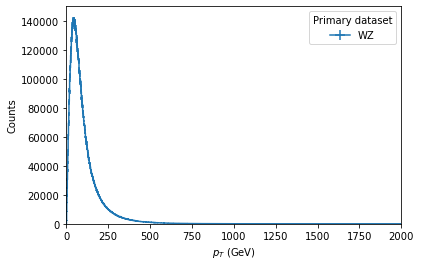

In [123]:
ax = hist.plot1d(met_hist,overlay="dataset")

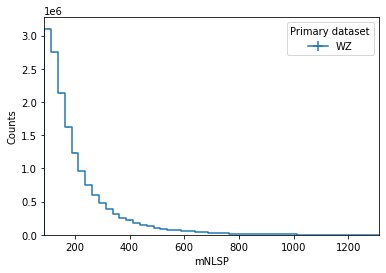

In [124]:
ax = hist.plot1d(mNLSP_hist,overlay="dataset")

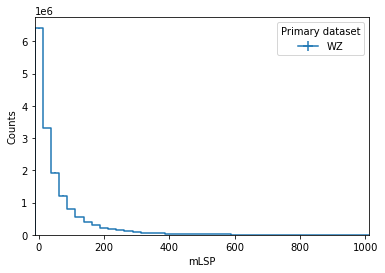

In [125]:
ax = hist.plot1d(mLSP_hist,overlay="dataset")

Now, try to rebin the NLSP and LSP mass axis and then sum over the axis.

In [126]:
def getMassPoint(histogram, mNLSP=800, mLSP=100, axis='pt'):
    bins_mNLSP = hist.Bin('mNLSP', 'NLSP mass', 1, mNLSP-12.5, mNLSP+12.5)
    bins_mLSP  = hist.Bin('mLSP', 'LSP mass', 1, mLSP-12.5, mLSP+12.5)
    tmp = histogram.copy()
    tmp  = tmp.rebin('mNLSP', bins_mNLSP)
    tmp  = tmp.rebin('mLSP', bins_mLSP)
    tmp = tmp.copy().project("dataset",axis)
    nEvents = tmp.sum("dataset").values(overflow='over')[()].sum()
    print ("Total number of events for signal point: %s"%nEvents)
    return tmp

Total number of events for signal point: 184.0622450212104


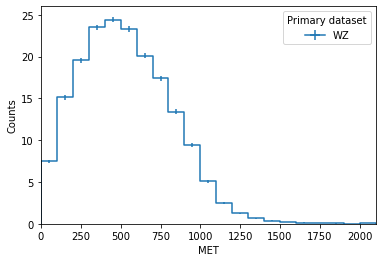

In [127]:
myhist = getMassPoint(output["MET_pt_baseline"], 1000,0)
met_bins   = hist.Bin('pt', 'MET', 20, 0, 2000)
myhist = myhist.rebin('pt', met_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 0.4884508738905424


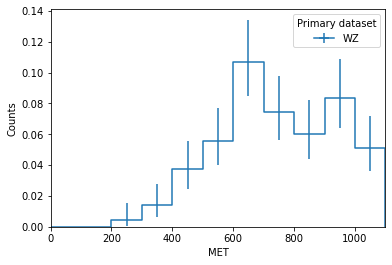

In [128]:
myhist = getMassPoint(output["MET_pt"], 1000,0)
met_bins   = hist.Bin('pt', 'MET', 10, 0, 1000)
myhist = myhist.rebin('pt', met_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 0.4884508738905424


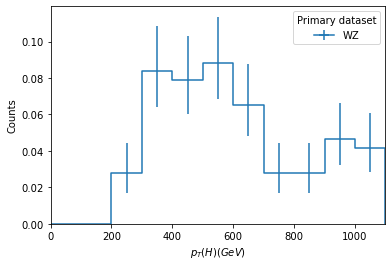

In [129]:
myhist = getMassPoint(output["Higgs_pt"], 1000,0)
new_bins   = hist.Bin('pt', r'$p_T(H) (GeV)$', 10, 0, 1000)
myhist = myhist.rebin('pt', new_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 5.202719501412503


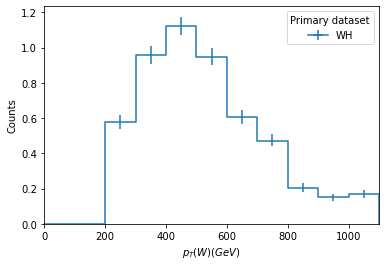

In [43]:
myhist = getMassPoint(output["W_pt"], 1000,0)
new_bins   = hist.Bin('pt', r'$p_T(W) (GeV)$', 10, 0, 1000)
myhist = myhist.rebin('pt', new_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 5.202719501412503


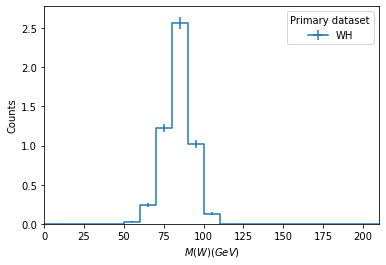

In [44]:
myhist = getMassPoint(output["W_msoftdrop"], mNLSP=1000, mLSP=0, axis='mass')
new_bins   = hist.Bin('mass', r'$M(W) (GeV)$', 20, 0, 200)
myhist = myhist.rebin('mass', new_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 5.202719501412503


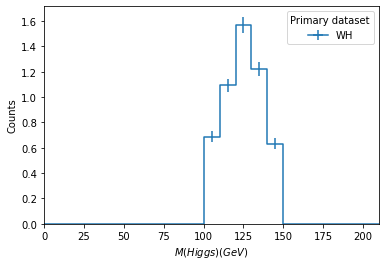

In [47]:
myhist = getMassPoint(output["Higgs_msoftdrop"], mNLSP=1000, mLSP=0, axis='mass')
new_bins   = hist.Bin('mass', r'$M(Higgs) (GeV)$', 20, 0, 200)
myhist = myhist.rebin('mass', new_bins)
ax = hist.plot1d(myhist,overlay="dataset", overflow='over')

Total number of events for signal point: 917.0177256498573
Total number of events for signal point: 184.06223814175246


<AxesSubplot:xlabel='MET', ylabel='Counts'>

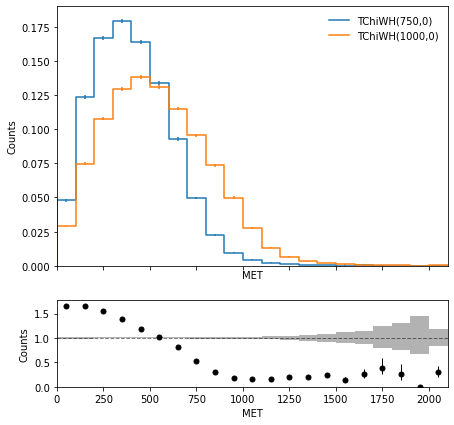

In [60]:
# An example of comparing two shapes.
# density=True is not working with coffea hist objects that only have one dataset

from plots.helpers import *

met_bins   = hist.Bin('pt', 'MET', 20, 0, 2000)


met_1 = getMassPoint(output["MET_pt_baseline"], 750,0)
# the above line is equivalent to met_1 = output['MET_pt']
met_1 = met_1.rebin('pt', met_bins) # optional line
met_1_norm = met_1["WH"].sum("dataset").values(overflow='over')[()].sum()
#met_1_norm = met_1.sum("dataset").values(overflow='over')[()].sum()
met_1.scale({'WH':1/met_1_norm}, axis='dataset')

met_2 = getMassPoint(output["MET_pt_baseline"], 1000,0)
met_2 = met_2.rebin('pt', met_bins)
met_2_norm = met_2.sum("dataset").values(overflow='over')[()].sum()
met_2.scale({'WH':1/met_2_norm}, axis='dataset')

fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)

ax = hist.plot1d(met_1,overlay="dataset", ax=ax, overflow='over')
ax = hist.plot1d(met_2,overlay="dataset", ax=ax, overflow='over', clear=False)

ax.legend(title='',ncol=1, labels=["TChiWH(750,0)", "TChiWH(1000,0)"], frameon=False)

hist.plotratio(
            num=met_1.sum("dataset"),
            denom=met_2.sum("dataset"),
            ax=rax,
            error_opts=data_err_opts,
            #error_opts={},
            denom_fill_opts={},
            guide_opts={},
            unc='num',
            overflow='over'
        )

In [52]:
met_1_norm

917.0177256498573

In [50]:
met_1

<Hist (dataset,pt) instance at 0x7f0b3f2e3b80>

## Write some data card

First, we need to get the background histograms from a cache.

Then, let's make a card for each bin, e.g. in terms of Higgs pt, containing a histogram of MET.

We can use the combine tool to combine those cards.


In [44]:
from Tools.dataCard import *

/home/users/dspitzba/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


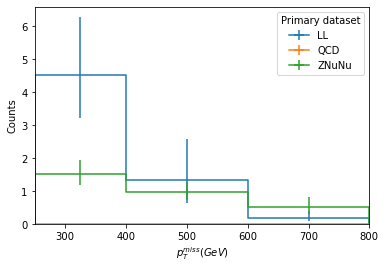

In [45]:
# 
import re
notsignal = re.compile('(?!(1000_1_scan|750_1_scan|mC750_l1))')

# Load the background histograms
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), 'WH'), serialized=True)

cache.load()

background_output = cache.get('simple_output')

background_met = background_output['MET_pt_SR'].copy()
met_bins   = hist.Bin('pt', r'$p_T^{miss} (GeV)$', np.array([250,400,600]))
background_met = background_met.rebin('pt', met_bins)
background_met = background_met[notsignal]
ax = hist.plot1d(background_met, overlay="dataset", overflow='over')

Total number of events for signal point: 7.995944015503483


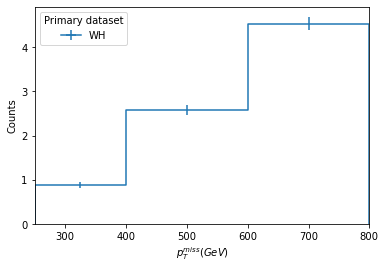

In [42]:
# now, signal
signal_met = getMassPoint(output["MET_pt"], mNLSP=900, mLSP=0)
met_bins   = hist.Bin('pt', r'$p_T^{miss} (GeV)$', np.array([250,400,600]))
signal_met = signal_met.rebin('pt', met_bins)
ax = hist.plot1d(signal_met, overlay="dataset", overflow='over')

In [84]:
from Tools.helpers import export1d
import uproot # use some old uproot3 here

def makeSignalHist(signal_hist, mNLSP, mLSP):
    tmp_hist = getMassPoint(signal_hist, mNLSP=mNLSP, mLSP=mLSP)
    new_bins = hist.Bin('pt', r'$p_T^{miss} (GeV)$', np.array([250,400,600])) # hard coded new binning
    tmp_hist = tmp_hist.rebin('pt', new_bins)
    return tmp_hist
    #ax = hist.plot1d(signal_met, overlay="dataset", overflow='over')

def makeCardFromHist(name, background_hist, signal_hist, LL_scale=1, Znunu_scale=1, QCD_scale=1, signal_scale=1, overflow='all', ext=''):
    hist_name = name
    bkg_hist = background_hist.copy()
    print ("Writing cards using histogram:", hist_name)
    
    card_dir = os.path.expandvars('$TWHOME/data/cards/')
    if not os.path.isdir(card_dir):
        os.makedirs(card_dir)
    
    data_card = card_dir+hist_name+ext+'_card.txt'
    shape_file = card_dir+hist_name+ext+'_shapes.root'
    
    #histogram = output[hist_name]
    #histogram = histogram.rebin('mass', bins[hist_name]['bins'])
    
    # scale some processes
    scales = { 
        'LL': LL_scale, 
        'WH': signal_scale,
        'ZNuNu': Znunu_scale, # only scale the most important backgrounds
        'QCD': QCD_scale,
    }
    bkg_hist.scale(scales, axis='dataset')
    signal_hist.scale(scales, axis='dataset')
    
    # let's fill a sum(MC) histogram ourselves
    bin_values    = bkg_hist.axis('pt').centers(overflow=overflow)
    poisson_means = np.round(bkg_hist[notsignal].integrate('dataset').values(overflow=overflow)[()],0)
    values        = np.repeat(bin_values, poisson_means.astype(int))
    bkg_hist.fill(dataset='observation', pt=values)
    #poisson_means = background_hist.integrate('dataset').values(overflow=overflow)[()]
    
    #observation = hist.export1d(histogram['pseudodata'].integrate('dataset'), overflow=overflow)
    observation = export1d(bkg_hist['observation'].integrate('dataset'), overflow=overflow)
    WH          = export1d(signal_hist.integrate('dataset'), overflow=overflow)
    LL          = export1d(bkg_hist['LL'].integrate('dataset'), overflow=overflow)
    ZNuNu       = export1d(bkg_hist['ZNuNu'].integrate('dataset'), overflow=overflow)
    QCD         = export1d(bkg_hist['QCD'].integrate('dataset'), overflow=overflow)
    
    file = uproot.recreate(shape_file, compression=uproot.ZLIB(4))
    
    file["signal"]    = WH
    file["LL"]        = LL
    file["ZNuNu"]     = ZNuNu
    file["QCD"]       = QCD
    file["data_obs"]  = observation
    
    # Get the total yields to write into a data card
    totals = {}
    
    totals['signal']      = signal_hist.integrate('dataset').values(overflow=overflow)[()].sum()
    totals['LL']          = bkg_hist['LL'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['ZNuNu']       = bkg_hist['ZNuNu'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['QCD']         = bkg_hist['QCD'].integrate('dataset').values(overflow=overflow)[()].sum()
    #totals['observation'] = histogram['pseudodata'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['observation'] = bkg_hist['observation'].integrate('dataset').values(overflow=overflow)[()].sum()
    
    print ("{:30}{:.2f}".format("Signal expectation:",totals['signal']) )
    print ("{:30}{:.2f}".format("Lost lepton background:",totals['LL']) )
    print ("{:30}{:.2f}".format("Z->inv background:",totals['ZNuNu']) )
    print ("{:30}{:.2f}".format("QCD background:",totals['QCD']) )
    print ("{:30}{:.2f}".format("Observation:", totals['observation']) )
    
    
    # set up the card
    card = dataCard()
    card.reset()
    card.setPrecision(3)
    
    # add the uncertainties (just flat ones for now)
    card.addUncertainty('lumi',  'lnN')
    card.addUncertainty('LL',    'lnN')
    card.addUncertainty('ZNuNu', 'lnN')
    card.addUncertainty('QCD',   'lnN')
    
    # add the single bin
    card.addBin('Bin0', [ 'LL', 'ZNuNu', 'QCD' ], 'Bin0')
    card.specifyExpectation('Bin0', 'signal', totals['signal'] )
    card.specifyExpectation('Bin0', 'LL', totals['LL'] )
    card.specifyExpectation('Bin0', 'ZNuNu', totals['ZNuNu'] )
    card.specifyExpectation('Bin0', 'QCD', totals['QCD'] )
    
    # set uncertainties
    card.specifyUncertainty('LL', 'Bin0', 'LL', 1.15 )
    card.specifyUncertainty('ZNuNu', 'Bin0', 'ZNuNu', 1.20 )
    card.specifyUncertainty('QCD', 'Bin0', 'QCD', 1.50 )
    card.specifyFlatUncertainty('lumi', 1.03)
    
    # observation
    card.specifyObservation('Bin0', int(round(totals['observation'],0)))
    
    print ("Done.\n")
    
    return card.writeToFile(data_card, shapeFile=shape_file)

In [85]:
signal_met = makeSignalHist(output["MET_pt"], mNLSP=1000, mLSP=0)
card_name = makeCardFromHist('WH_1000_0', background_met, signal_met)

Total number of events for signal point: 5.202719501412503
Writing cards using histogram: WH_1000_0
Signal expectation:           5.20
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_0_card.txt


In [86]:
from Tools.dataCard import *
card = dataCard()

In [87]:
results_SR = card.calcLimit(card_name, verbose=True)
results_SR

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/notebooks/a94017cc-986a-4063-b96e-f47fe06c8aa8
Executing command: cd /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/notebooks/a94017cc-986a-4063-b96e-f47fe06c8aa8;eval `scramv1 runtime -sh`;combine --saveWorkspace -M AsymptoticLimits  /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_0_card.txt
{'-2sig': 0.489593505859375, '-1sig': 0.6870486736297607, 'expected': 1.02734375, '+1sig': 1.5842686891555786, '+2sig': 2.3661646842956543, 'observed': 1.0567724513579286}


{'-2sig': 0.489593505859375,
 '-1sig': 0.6870486736297607,
 'expected': 1.02734375,
 '+1sig': 1.5842686891555786,
 '+2sig': 2.3661646842956543,
 'observed': 1.0567724513579286,
 'card': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_0_card.txt'}

In [114]:
card.cleanUp()

## Missing k-factor for LL

Tested on one signal point, (1000,0), the expected limit changes from 
1.0078125 -> 1.08984375 with a 1.5 scale for LL

# Now run the full scan

In [89]:
signal_dict

[{'mNLSP': 975, 'mLSP': 75, 'sumweight': 78808.0, 'xsec': 1.56893},
 {'mNLSP': 525, 'mLSP': 150, 'sumweight': 84409.0, 'xsec': 37.2636},
 {'mNLSP': 425, 'mLSP': 125, 'sumweight': 106379.0, 'xsec': 93.771},
 {'mNLSP': 1175, 'mLSP': 500, 'sumweight': 98425.0, 'xsec': 0.486863},
 {'mNLSP': 1050, 'mLSP': 375, 'sumweight': 65355.0, 'xsec': 0.997903},
 {'mNLSP': 1025, 'mLSP': 275, 'sumweight': 89962.0, 'xsec': 1.15949},
 {'mNLSP': 1150, 'mLSP': 50, 'sumweight': 82626.0, 'xsec': 0.555594},
 {'mNLSP': 725, 'mLSP': 250, 'sumweight': 102518.0, 'xsec': 7.9595},
 {'mNLSP': 550, 'mLSP': 175, 'sumweight': 94277.0, 'xsec': 30.1656},
 {'mNLSP': 300, 'mLSP': 50, 'sumweight': 104420.0, 'xsec': 386.936},
 {'mNLSP': 800, 'mLSP': 250, 'sumweight': 84722.0, 'xsec': 4.75843},
 {'mNLSP': 975, 'mLSP': 125, 'sumweight': 80669.0, 'xsec': 1.56893},
 {'mNLSP': 750, 'mLSP': 175, 'sumweight': 78667.0, 'xsec': 6.69356},
 {'mNLSP': 975, 'mLSP': 375, 'sumweight': 92463.0, 'xsec': 1.56893},
 {'mNLSP': 1275, 'mLSP': 375,

In [90]:
allCards = []

#def ()

for index, row in signal_df.iterrows():
    mNLSP = int(row['mNLSP'])
    mLSP = int(row['mLSP'])
    if mLSP == 1: mLSP = 0
    signal_met = makeSignalHist(output["MET_pt"], mNLSP=mNLSP, mLSP=mLSP)
    card_name  = makeCardFromHist('WH_%s_%s'%(mNLSP, mLSP), background_met, signal_met)
    allCards.append(card_name)
    print(card_name)
    
print ("Done.")

Total number of events for signal point: 5.874887344794843
Writing cards using histogram: WH_975_75
Signal expectation:           5.87
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_75_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_75_card.txt
Total number of events for signal point: 13.547670865431428
Writing cards using histogram: WH_525_150
Signal expectation:           13.55
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_525_150_card.txt
/home/user

Total number of events for signal point: 14.005643404125294
Writing cards using histogram: WH_725_125
Signal expectation:           14.01
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_125_card.txt
Total number of events for signal point: 20.072145771235228
Writing cards using histogram: WH_450_75
Signal expectation:           20.07
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_450_75_card.txt
/home/u

Total number of events for signal point: 5.386758693739466
Writing cards using histogram: WH_975_150
Signal expectation:           5.39
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_150_card.txt
Total number of events for signal point: 13.442892431718064
Writing cards using histogram: WH_650_200
Signal expectation:           13.44
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_200_card.txt
/home/u

Total number of events for signal point: 4.05887165185959
Writing cards using histogram: WH_1050_150
Signal expectation:           4.06
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1050_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1050_150_card.txt
Total number of events for signal point: 2.83824271161302
Writing cards using histogram: WH_1125_25
Signal expectation:           2.84
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_25_card.txt
/home/us

Total number of events for signal point: 22.731006746471394
Writing cards using histogram: WH_525_0
Signal expectation:           22.73
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_525_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_525_0_card.txt
Total number of events for signal point: 7.720785029385297
Writing cards using histogram: WH_875_225
Signal expectation:           7.72
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_225_card.txt
/home/users/d

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_475_card.txt
Total number of events for signal point: 1.489437134929176
Writing cards using histogram: WH_1250_275
Signal expectation:           1.49
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_275_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_275_card.txt
Total number of events for signal point: 22.47556881979108
Writing cards using histogram: WH_500_75
Signal expectation:           22.48
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observa

Total number of events for signal point: 2.600757404397882
Writing cards using histogram: WH_1100_400
Signal expectation:           2.60
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1100_400_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1100_400_card.txt
Total number of events for signal point: 0.36166289763059467
Writing cards using histogram: WH_425_275
Signal expectation:           0.36
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_425_275_card.txt
/hom

Signal expectation:           1.34
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_550_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_550_card.txt
Total number of events for signal point: 1.398416060026193
Writing cards using histogram: WH_1250_400
Signal expectation:           1.40
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_400_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_400_card.txt
Total number of ev

Total number of events for signal point: 1.1922578534667991
Writing cards using histogram: WH_925_600
Signal expectation:           1.19
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_600_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_600_card.txt
Total number of events for signal point: 6.541089448146522
Writing cards using histogram: WH_925_225
Signal expectation:           6.54
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_225_card.txt
/home/us

Signal expectation:           0.99
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_350_200_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_350_200_card.txt
Total number of events for signal point: 1.7998021365674504
Writing cards using histogram: WH_1225_125
Signal expectation:           1.80
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_125_card.txt
Total number of eve

Total number of events for signal point: 3.1735235956439283
Writing cards using histogram: WH_1000_475
Signal expectation:           3.17
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_475_card.txt
Total number of events for signal point: 1.3773826012557038
Writing cards using histogram: WH_1275_275
Signal expectation:           1.38
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1275_275_card.txt
/h

Signal expectation:           2.31
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1175_50_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1175_50_card.txt
Total number of events for signal point: 0.8368275391403586
Writing cards using histogram: WH_350_175
Signal expectation:           0.84
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_350_175_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_350_175_card.txt
Total number of events

Total number of events for signal point: 0.0
Writing cards using histogram: WH_625_500
Signal expectation:           0.00
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_500_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_500_card.txt
Total number of events for signal point: 4.935921207303181
Writing cards using histogram: WH_1000_150
Signal expectation:           4.94
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_150_card.txt
/home/users/dspitzba/

Writing cards using histogram: WH_1125_300
Signal expectation:           2.66
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_300_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_300_card.txt
Total number of events for signal point: 2.7152910749427974
Writing cards using histogram: WH_375_150
Signal expectation:           2.72
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/car

Total number of events for signal point: 1.54909663226681
Writing cards using histogram: WH_1250_200
Signal expectation:           1.55
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_200_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1250_200_card.txt
Total number of events for signal point: 13.156031493621413
Writing cards using histogram: WH_625_200
Signal expectation:           13.16
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_200_card.txt
/home

Signal expectation:           15.74
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_475_100_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_475_100_card.txt
Total number of events for signal point: 7.924240209860727
Writing cards using histogram: WH_575_250
Signal expectation:           7.92
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_250_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_250_card.txt
Total number of events

Signal expectation:           2.54
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_0_card.txt
Total number of events for signal point: 0.08207989374204772
Writing cards using histogram: WH_775_600
Signal expectation:           0.08
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_775_600_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_775_600_card.txt
Total number of events 

Signal expectation:           1.90
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_575_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_575_card.txt
Total number of events for signal point: 0.3005099860019982
Writing cards using histogram: WH_650_450
Signal expectation:           0.30
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_450_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_450_card.txt
Total number of events

Total number of events for signal point: 9.021715578943258
Writing cards using histogram: WH_650_275
Signal expectation:           9.02
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_275_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_275_card.txt
Total number of events for signal point: 1.7142000286403345
Writing cards using histogram: WH_625_375
Signal expectation:           1.71
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_375_card.txt
/home/us

Total number of events for signal point: 21.970276723848656
Writing cards using histogram: WH_600_0
Signal expectation:           21.97
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_0_card.txt
Total number of events for signal point: 1.5044750109736924
Writing cards using histogram: WH_750_475
Signal expectation:           1.50
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_750_475_card.txt
/home/users/

Writing cards using histogram: WH_850_25
Signal expectation:           9.75
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_850_25_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_850_25_card.txt
Total number of events for signal point: 2.846073380960661
Writing cards using histogram: WH_1125_175
Signal expectation:           2.85
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_175_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH

Total number of events for signal point: 1.8193228808231652
Writing cards using histogram: WH_900_550
Signal expectation:           1.82
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_550_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_550_card.txt
Total number of events for signal point: 0.15140466839511646
Writing cards using histogram: WH_750_550
Signal expectation:           0.15
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_750_550_card.txt
/home/

Signal expectation:           1.42
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1175_600_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1175_600_card.txt
Total number of events for signal point: 3.419048278752598
Writing cards using histogram: WH_950_475
Signal expectation:           3.42
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_950_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_950_475_card.txt
Total number of event

Writing cards using histogram: WH_875_150
Signal expectation:           8.47
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_150_card.txt
Total number of events for signal point: 20.316405864141416
Writing cards using histogram: WH_550_100
Signal expectation:           20.32
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_550_100_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards

Writing cards using histogram: WH_450_125
Signal expectation:           12.88
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_450_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_450_125_card.txt
Total number of events for signal point: 3.4005130603327416
Writing cards using histogram: WH_825_450
Signal expectation:           3.40
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_825_450_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards

Writing cards using histogram: WH_725_275
Signal expectation:           9.90
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_275_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_275_card.txt
Total number of events for signal point: 7.165463795798132
Writing cards using histogram: WH_800_325
Signal expectation:           7.17
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_325_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/W

Total number of events for signal point: 1.6666415109057198
Writing cards using histogram: WH_1225_350
Signal expectation:           1.67
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_350_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_350_card.txt
Total number of events for signal point: 2.065532764708678
Writing cards using histogram: WH_1150_450
Signal expectation:           2.07
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_450_card.txt
/ho

Writing cards using histogram: WH_900_250
Signal expectation:           7.05
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_250_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_250_card.txt
Total number of events for signal point: 6.372100167052849
Writing cards using histogram: WH_825_350
Signal expectation:           6.37
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_825_350_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/W

Total number of events for signal point: 8.993193090136629
Writing cards using histogram: WH_875_50
Signal expectation:           8.99
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_50_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_50_card.txt
Total number of events for signal point: 1.6412547680438365
Writing cards using histogram: WH_1125_600
Signal expectation:           1.64
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_600_card.txt
/home/use

Total number of events for signal point: 18.984224616069696
Writing cards using histogram: WH_650_0
Signal expectation:           18.98
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_0_card.txt
Total number of events for signal point: 10.014375939499587
Writing cards using histogram: WH_800_225
Signal expectation:           10.01
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_225_card.txt
/home/users

Total number of events for signal point: 3.1182701903862835
Writing cards using histogram: WH_1075_375
Signal expectation:           3.12
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1075_375_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1075_375_card.txt
Total number of events for signal point: 14.53024333997746
Writing cards using histogram: WH_625_175
Signal expectation:           14.53
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_175_card.txt
/hom

Total number of events for signal point: 2.4730997172264324
Writing cards using histogram: WH_1125_400
Signal expectation:           2.47
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_400_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_400_card.txt
Total number of events for signal point: 6.9817451167837135
Writing cards using histogram: WH_875_275
Signal expectation:           6.98
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_275_card.txt
/hom

Signal expectation:           1.26
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_175_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_175_card.txt
Total number of events for signal point: 7.728933088677877
Writing cards using histogram: WH_850_275
Signal expectation:           7.73
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_850_275_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_850_275_card.txt
Total number of event

Signal expectation:           15.16
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_25_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_725_25_card.txt
Total number of events for signal point: 1.2758875413564965
Writing cards using histogram: WH_425_225
Signal expectation:           1.28
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_425_225_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_425_225_card.txt
Total number of events 

Total number of events for signal point: 6.926845619964297
Writing cards using histogram: WH_925_125
Signal expectation:           6.93
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_125_card.txt
Total number of events for signal point: 4.931665583990252
Writing cards using histogram: WH_1000_100
Signal expectation:           4.93
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1000_100_card.txt
/home/u

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_750_50_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_750_50_card.txt
Total number of events for signal point: 4.1323225085061495
Writing cards using histogram: WH_1050_50
Signal expectation:           4.13
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1050_50_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1050_50_card.txt
Total number of events for signal point: 0.46338142739841715
Writing cards using histogram: WH_850_600
Signal expectation:           0.46
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation

Total number of events for signal point: 23.348059409094276
Writing cards using histogram: WH_575_0
Signal expectation:           23.35
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_0_card.txt
Total number of events for signal point: 16.242950617452152
Writing cards using histogram: WH_425_75
Signal expectation:           16.24
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_425_75_card.txt
/home/users/d

Total number of events for signal point: 20.131057994120056
Writing cards using histogram: WH_575_125
Signal expectation:           20.13
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_125_card.txt
Total number of events for signal point: 0.0
Writing cards using histogram: WH_250_125
Signal expectation:           0.00
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_250_125_card.txt
/home/users/dspitzba/

Total number of events for signal point: 2.0594768060545903
Writing cards using histogram: WH_1125_525
Signal expectation:           2.06
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_525_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_525_card.txt
Total number of events for signal point: 2.4521099416806464
Writing cards using histogram: WH_1150_200
Signal expectation:           2.45
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_200_card.txt
/h

Writing cards using histogram: WH_800_425
Signal expectation:           4.14
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_425_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_425_card.txt
Total number of events for signal point: 22.05641913213185
Writing cards using histogram: WH_625_0
Signal expectation:           22.06
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_6

Total number of events for signal point: 2.7100852822604793
Writing cards using histogram: WH_1025_500
Signal expectation:           2.71
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1025_500_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1025_500_card.txt
Total number of events for signal point: 7.2993929185395245
Writing cards using histogram: WH_925_75
Signal expectation:           7.30
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_75_card.txt
/home/

Writing cards using histogram: WH_550_150
Signal expectation:           14.96
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_550_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_550_150_card.txt
Total number of events for signal point: 1.6790147079382223
Writing cards using histogram: WH_1225_225
Signal expectation:           1.68
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_225_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/car

Total number of events for signal point: 0.06532258981314953
Writing cards using histogram: WH_650_475
Signal expectation:           0.07
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_475_card.txt
Total number of events for signal point: 17.888761453796178
Writing cards using histogram: WH_650_50
Signal expectation:           17.89
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_650_50_card.txt
/home/u

Writing cards using histogram: WH_900_400
Signal expectation:           4.90
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_400_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_900_400_card.txt
Total number of events for signal point: 0.0
Writing cards using histogram: WH_375_250
Signal expectation:           0.00
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_250_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_250_card

Total number of events for signal point: 1.9298885001626331
Writing cards using histogram: WH_700_425
Signal expectation:           1.93
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_700_425_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_700_425_card.txt
Total number of events for signal point: 6.195755499909865
Writing cards using histogram: WH_950_75
Signal expectation:           6.20
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_950_75_card.txt
/home/user

Total number of events for signal point: 1.3250551423989236
Writing cards using histogram: WH_600_375
Signal expectation:           1.33
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_375_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_375_card.txt
Total number of events for signal point: 15.204085438977927
Writing cards using histogram: WH_700_150
Signal expectation:           15.20
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_700_150_card.txt
/home/

Total number of events for signal point: 1.4082202910969954
Writing cards using histogram: WH_1275_100
Signal expectation:           1.41
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1275_100_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1275_100_card.txt
Total number of events for signal point: 4.611719198239371
Writing cards using histogram: WH_1025_125
Signal expectation:           4.61
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1025_125_card.txt
/ho

Signal expectation:           19.01
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_400_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_400_0_card.txt
Total number of events for signal point: 1.536359571318826
Writing cards using histogram: WH_975_600
Signal expectation:           1.54
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_600_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_975_600_card.txt
Total number of events for

Total number of events for signal point: 7.022698246320942
Writing cards using histogram: WH_875_300
Signal expectation:           7.02
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_300_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_875_300_card.txt
Total number of events for signal point: 3.4274342358112335
Writing cards using histogram: WH_225_50
Signal expectation:           3.43
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_225_50_card.txt
/home/user

Signal expectation:           8.36
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_150_0_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_150_0_card.txt
Total number of events for signal point: 1.2776445508279721
Writing cards using histogram: WH_1225_600
Signal expectation:           1.28
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_600_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_600_card.txt
Total number of events 

Total number of events for signal point: 17.045759330270812
Writing cards using histogram: WH_375_25
Signal expectation:           17.05
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_25_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_25_card.txt
Total number of events for signal point: 1.1572687193624915
Writing cards using histogram: WH_1275_525
Signal expectation:           1.16
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1275_525_card.txt
/home/u

Writing cards using histogram: WH_1300_250
Signal expectation:           1.26
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_250_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_250_card.txt
Total number of events for signal point: 9.482936652202625
Writing cards using histogram: WH_850_150
Signal expectation:           9.48
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_850_150_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/card

Total number of events for signal point: 6.446901067480212
Writing cards using histogram: WH_800_350
Signal expectation:           6.45
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_350_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_350_card.txt
Total number of events for signal point: 1.9909131894955863
Writing cards using histogram: WH_1125_550
Signal expectation:           1.99
Lost lepton background:       4.79
Z->inv background:            2.62
QCD background:               0.00
Observation:                  8.00
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_550_card.txt
/home/

In [91]:
signal_df['cards'] = allCards

In [92]:
signal_df

,mNLSP,mLSP,sumweight,xsec,cards,expected,+2sig,+1sig,-1sig,-2sig,observed
0,975,75,78808.0,1.568930,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,0.824219,1.955516,1.290741,0.543711,0.386353,0.975217
1,525,150,84409.0,37.263600,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,0.470703,1.046776,0.712738,0.319443,0.231674,0.494540
2,425,125,106379.0,93.771000,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,0.566406,1.334190,0.880229,0.378791,0.269928,0.556242
3,1175,500,98425.0,0.486863,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,2.773438,6.548215,4.343253,1.829548,1.300049,3.276912
4,1050,375,65355.0,0.997903,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,1.488281,3.513902,2.330675,0.981771,0.697632,1.756015
...,...,...,...,...,...,...,...,...,...,...,...
894,1125,550,81912.0,0.647288,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,2.562500,6.045474,4.002707,1.690399,1.201172,3.007046
895,1100,125,79457.0,0.740372,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,1.476562,3.503246,2.312324,0.970346,0.686371,1.748856
896,1275,150,80477.0,0.276522,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,3.296875,7.865902,5.176107,2.174843,1.545410,3.926070
897,1250,300,71145.0,0.316975,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...,3.085938,7.362634,4.844934,2.027972,1.434479,3.666334


In [93]:
import concurrent.futures
import time

tstart = time.time()

allResults = []
allExpected = []

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for result in executor.map(card.calcLimit, allCards):
        print (result['card'])
        allResults.append(result)
        try:
            allExpected.append(result['expected'])
        except KeyError:
            allExpected.append(-99)

elapsed = time.time() - tstart

signal_df['expected'] = allExpected

print ("Getting the limits took: %s s"%elapsed)

{'-2sig': 0.316925048828125, '-1sig': 0.44080376625061035, 'expected': 0.654296875, '+1sig': 1.0011682510375977, '+2sig': 1.479950189590454, 'observed': 0.6816868620093444}
{'-2sig': 1.29296875, '-1sig': 1.767730712890625, 'expected': 2.5859375, '+1sig': 3.8537793159484863, '+2sig': 5.592350959777832, 'observed': 2.7439705551830533}
{'-2sig': 1.02117919921875, '-1sig': 1.5019521713256836, 'expected': 2.640625, '+1sig': 5.314138889312744, '+2sig': 8.008539199829102, 'observed': 2.9951360246818743}
{'-2sig': 1.4669189453125, '-1sig': 2.0585336685180664, 'expected': 3.078125, '+1sig': 4.75905179977417, '+2sig': 7.077563285827637, 'observed': 3.1739864054837277}
{'-2sig': 0.298828125, '-1sig': 0.410888671875, 'expected': 0.59765625, '+1sig': 0.8906770944595337, '+2sig': 1.2888720035552979, 'observed': 0.6370859443878153}
{'-2sig': 0.2744140625, '-1sig': 0.3773193359375, 'expected': 0.548828125, '+1sig': 0.8179093599319458, '+2sig': 1.1802477836608887, 'observed': 0.585514578966293}
{'-2sig

{'-2sig': 0.16015625, '-1sig': 0.218963623046875, 'expected': 0.3203125, '+1sig': 0.4773563742637634, '+2sig': 0.6907680630683899, 'observed': 0.34022142279562106}
{'-2sig': 0.92333984375, '-1sig': 1.2957267761230469, 'expected': 1.9375, '+1sig': 2.9800994396209717, '+2sig': 4.45862340927124, 'observed': 1.9933138134679702}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1100_325_card.txt
{'-2sig': 0.5950927734375, '-1sig': 0.8322000503540039, 'expected': 1.26953125, '+1sig': 2.069075345993042, '+2sig': 3.6085457801818848, 'observed': 1.368815401132228}
{'-2sig': 0.1698150634765625, '-1sig': 0.23619186878204346, 'expected': 0.3505859375, '+1sig': 0.5336519479751587, '+2sig': 0.7853077054023743, 'observed': 0.36672264946950395}
{'-2sig': 0.90472412109375, '-1sig': 1.2618398666381836, 'expected': 1.8984375, '+1sig': 2.9200167655944824, '+2sig': 4.36873197555542, 'observed': 1.9423113833432029}
{'-2sig': 0.2195892333984375, '-1sig': 0.30677497386932373, 'expected': 0

{'-2sig': 0.4321441650390625, '-1sig': 0.5933209657669067, 'expected': 0.87109375, '+1sig': 1.3120653629302979, '+2sig': 1.917804479598999, 'observed': 0.9322541813101005}
{'-2sig': 0.5733642578125, '-1sig': 0.8046045303344727, 'expected': 1.203125, '+1sig': 1.8505455255508423, '+2sig': 2.761598825454712, 'observed': 1.237130662140136}
{'-2sig': 0.7833251953125, '-1sig': 1.0895090103149414, 'expected': 1.6171875, '+1sig': 2.474529266357422, '+2sig': 3.6483633518218994, 'observed': 1.691189427197944}
{'-2sig': 5.3902587890625, '-1sig': 7.484872817993164, 'expected': 11.21875, '+1sig': 17.7923583984375, '+2sig': 28.886367797851562, 'observed': 12.132243731405525}
{'-2sig': 0.72265625, '-1sig': 0.99365234375, 'expected': 1.4453125, '+1sig': 2.1539249420166016, '+2sig': 3.108125925064087, 'observed': 1.5414297336537315}
{'-2sig': 1.22119140625, '-1sig': 1.7137031555175781, 'expected': 2.5625, '+1sig': 3.961850166320801, '+2sig': 5.921905994415283, 'observed': 2.6260564960936064}
{'-2sig': 

{'-2sig': 0.638519287109375, '-1sig': 0.8960368633270264, 'expected': 1.33984375, '+1sig': 2.0661754608154297, '+2sig': 3.0859105587005615, 'observed': 1.3784056074952558}
{'-2sig': 1.591552734375, '-1sig': 2.2234630584716797, 'expected': 3.3125, '+1sig': 5.068601131439209, '+2sig': 7.51207160949707, 'observed': 3.4462875419955843}
{'-2sig': 1.036865234375, '-1sig': 1.4421520233154297, 'expected': 2.140625, '+1sig': 3.2583985328674316, '+2sig': 4.794970512390137, 'observed': 2.239091079820473}
{'-2sig': 1.03875732421875, '-1sig': 1.4576926231384277, 'expected': 2.1796875, '+1sig': 3.361299991607666, '+2sig': 5.032988548278809, 'observed': 2.235142828903369}
{'-2sig': 2.11474609375, '-1sig': 2.967632293701172, 'expected': 4.4375, '+1sig': 6.860764980316162, '+2sig': 10.25500774383545, 'observed': 4.571093654343568}
{'-2sig': 1.2733154296875, '-1sig': 1.786849021911621, 'expected': 2.671875, '+1sig': 4.130953311920166, '+2sig': 6.174670219421387, 'observed': 2.7410992981968576}
{'-2sig':

{'-2sig': 1.1541748046875, '-1sig': 1.6196584701538086, 'expected': 2.421875, '+1sig': 3.7251241207122803, '+2sig': 5.559062480926514, 'observed': 2.492716565602504}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_375_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_800_450_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1125_300_card.txt
{'-2sig': 0.28839111328125, '-1sig': 0.397646427154541, 'expected': 0.5859375, '+1sig': 0.8895618319511414, '+2sig': 1.3182305097579956, 'observed': 0.6297158557336754}
{'-2sig': 1.93603515625, '-1sig': 2.716846466064453, 'expected': 4.0625, '+1sig': 6.264788627624512, '+2sig': 9.33291244506836, 'observed': 4.195817523261939}
{'-2sig': 1.29937744140625, '-1sig': 1.8234219551086426, 'expected': 2.7265625, '+1sig': 4.215505123138428, '+2sig': 6.301052570343018, 'observed': 2.8087306127617664}
{'-2sig': 1.14111328125, '-1sig': 1.6186103820800781, 'expected': 2.5625, '

{'-2sig': 2.025390625, '-1sig': 2.8422393798828125, 'expected': 4.25, '+1sig': 6.570873260498047, '+2sig': 9.821697235107422, 'observed': 4.375567519474309}
{'-2sig': 0.694427490234375, '-1sig': 0.9701430797576904, 'expected': 1.4453125, '+1sig': 2.217296838760376, '+2sig': 3.280620813369751, 'observed': 1.5038556219182526}
{'-2sig': 1.51904296875, '-1sig': 2.1316795349121094, 'expected': 3.1875, '+1sig': 4.915449619293213, '+2sig': 7.360069274902344, 'observed': 3.265440247702484}
{'-2sig': 1.7275390625, '-1sig': 2.4242630004882812, 'expected': 3.625, '+1sig': 5.590118885040283, '+2sig': 8.370274543762207, 'observed': 3.7064525959918724}
{'-2sig': 0.3388671875, '-1sig': 0.46329498291015625, 'expected': 0.677734375, '+1sig': 1.0127177238464355, '+2sig': 1.4712936878204346, 'observed': 0.7253608015723757}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_525_200_card.txt
{'-2sig': 0.7681884765625, '-1sig': 1.068455696105957, 'expected': 1.5859375, '+1sig': 2.40142583

{'-2sig': 1.0059814453125, '-1sig': 1.4053964614868164, 'expected': 2.09375, '+1sig': 3.2204298973083496, '+2sig': 4.805899143218994, 'observed': 2.162538486489362}
{'-2sig': 1.3031005859375, '-1sig': 1.8286466598510742, 'expected': 2.734375, '+1sig': 4.216684818267822, '+2sig': 6.281768321990967, 'observed': 2.8171194376803745}
{'-2sig': 1.5115966796875, '-1sig': 2.121230125427246, 'expected': 3.171875, '+1sig': 4.891354084014893, '+2sig': 7.305420875549316, 'observed': 3.2623344336359805}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_25_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1200_475_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1050_475_card.txt
{'-2sig': 1.39990234375, '-1sig': 1.9524765014648438, 'expected': 2.9375, '+1sig': 4.529923915863037, '+2sig': 6.765611171722412, 'observed': 3.0037967918

{'-2sig': 0.2685546875, '-1sig': 0.3692626953125, 'expected': 0.537109375, '+1sig': 0.8004451394081116, '+2sig': 1.1583000421524048, 'observed': 0.5742355547613387}
{'-2sig': 2.025390625, '-1sig': 2.8422393798828125, 'expected': 4.25, '+1sig': 6.570873260498047, '+2sig': 9.821697235107422, 'observed': 4.355402247811124}
{'-2sig': 0.693756103515625, '-1sig': 0.9580116271972656, 'expected': 1.3984375, '+1sig': 2.0952165126800537, '+2sig': 3.0727102756500244, 'observed': 1.493922423445587}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1300_125_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_575_275_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_500_125_card.txt
{'-2sig': 1.653076171875, '-1sig': 2.3197689056396484, 'expected': 3.46875, '+1sig': 5.349165916442871, '+2sig': 8.00948715209961, 'observed': 3.5549570195680555}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1225_425_card

{'-2sig': 7.8125, '-1sig': 1996.1090087890625, 'expected': 4000.0, '+1sig': 8049.8193359375, '+2sig': 12131.2783203125, 'observed': 23431.746418841525}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_200_75_card.txt
{'-2sig': 0.724151611328125, '-1sig': 1.016205072402954, 'expected': 1.51953125, '+1sig': 2.3432719707489014, '+2sig': 3.490868330001831, 'observed': 1.5646790080692594}
{'-2sig': 1.3775634765625, '-1sig': 1.933140754699707, 'expected': 2.890625, '+1sig': 4.469160079956055, '+2sig': 6.663320541381836, 'observed': 2.9822525343504975}
{'-2sig': 1.593505859375, '-1sig': 2.236173629760742, 'expected': 3.34375, '+1sig': 5.169731140136719, '+2sig': 7.727365016937256, 'observed': 3.433535608321743}
{'-2sig': 2.3409423828125, '-1sig': 3.214043617248535, 'expected': 4.71875, '+1sig': 7.107510566711426, '+2sig': 10.473685264587402, 'observed': 5.061270592729837}
{'-2sig': 0.9903564453125, '-1sig': 1.3897714614868164, 'expected': 2.078125, '+1sig': 3.212963819503

{'-2sig': 0.355682373046875, '-1sig': 0.4932975769042969, 'expected': 0.72265625, '+1sig': 1.082723617553711, '+2sig': 1.5747894048690796, 'observed': 0.763203109581895}
{'-2sig': 0.258270263671875, '-1sig': 0.3592221736907959, 'expected': 0.533203125, '+1sig': 0.811626672744751, '+2sig': 1.1943676471710205, 'observed': 0.5568426866238104}
{'-2sig': 1.157958984375, '-1sig': 1.6105785369873047, 'expected': 2.390625, '+1sig': 3.6579997539520264, '+2sig': 5.393232822418213, 'observed': 2.5008529115505835}
{'-2sig': 0.437469482421875, '-1sig': 0.6139028072357178, 'expected': 0.91796875, '+1sig': 1.4119422435760498, '+2sig': 2.0962870121002197, 'observed': 0.9474930986187932}
{'-2sig': 0.235565185546875, '-1sig': 0.32764220237731934, 'expected': 0.486328125, '+1sig': 0.7383363246917725, '+2sig': 1.088346004486084, 'observed': 0.5083279550317934}
{'-2sig': 0.4351806640625, '-1sig': 0.6052827835083008, 'expected': 0.8984375, '+1sig': 1.363994836807251, '+2sig': 2.0052552223205566, 'observed':

{'-2sig': 0.649688720703125, '-1sig': 0.9117109775543213, 'expected': 1.36328125, '+1sig': 2.107752561569214, '+2sig': 3.150526285171509, 'observed': 1.4044885401173457}
{'-2sig': 0.3251953125, '-1sig': 0.4471435546875, 'expected': 0.650390625, '+1sig': 0.9692662954330444, '+2sig': 1.3986567258834839, 'observed': 0.6922713318055543}
{'-2sig': 0.694366455078125, '-1sig': 0.974407434463501, 'expected': 1.45703125, '+1sig': 2.2468905448913574, '+2sig': 3.3643455505371094, 'observed': 1.5000986363782864}
{'-2sig': 1.5860595703125, '-1sig': 2.225724220275879, 'expected': 3.328125, '+1sig': 5.132307529449463, '+2sig': 7.684778213500977, 'observed': 3.4099290190588345}{'-2sig': 1.0499267578125, '-1sig': 1.4733667373657227, 'expected': 2.203125, '+1sig': 3.3974430561065674, '+2sig': 5.061310291290283, 'observed': 2.2663982031678254}

{'-2sig': 0.26744842529296875, '-1sig': 0.3736361861228943, 'expected': 0.556640625, '+1sig': 0.8561777472496033, '+2sig': 1.2711527347564697, 'observed': 0.57686

{'-2sig': 0.586395263671875, '-1sig': 0.8228909969329834, 'expected': 1.23046875, '+1sig': 1.90241277217865, '+2sig': 2.8364133834838867, 'observed': 1.268401835725322}{'-2sig': 2.24017333984375, '-1sig': 3.0934677124023438, 'expected': 4.515625, '+1sig': 6.747560024261475, '+2sig': 9.775690078735352, 'observed': 4.771665483917178}

{'-2sig': 0.45758056640625, '-1sig': 0.6309323310852051, 'expected': 0.9296875, '+1sig': 1.4188497066497803, '+2sig': 2.117445945739746, 'observed': 0.997912254697052}
{'-2sig': 0.19237518310546875, '-1sig': 0.26875585317611694, 'expected': 0.400390625, '+1sig': 0.6126551628112793, '+2sig': 0.9080039262771606, 'observed': 0.41682787401796784}
{'-2sig': 3.0615234375, '-1sig': 4.363105773925781, 'expected': 7.125, '+1sig': 14.338741302490234, '+2sig': 21.60883903503418, 'observed': 7.880949182327603}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_925_575_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1200

{'-2sig': 1.6903076171875, '-1sig': 2.357511520385742, 'expected': 3.546875, '+1sig': 5.469642639160156, '+2sig': 8.169116020202637, 'observed': 3.626010303646251}
{'-2sig': 0.177734375, '-1sig': 0.2429962158203125, 'expected': 0.35546875, '+1sig': 0.5325829386711121, '+2sig': 0.7703421711921692, 'observed': 0.37660962097384476}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_500_100_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1200_25_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_300_card.txt
{'-2sig': 2.79827880859375, '-1sig': 3.8419528007507324, 'expected': 5.640625, '+1sig': 8.541031837463379, '+2sig': 12.678484916687012, 'observed': 6.034598919374788}
{'-2sig': 1.062286376953125, '-1sig': 1.4840567111968994, 'expected': 2.2109375, '+1sig': 3.4094908237457275, '+2sig': 5.079258441925049, 'observed': 2.2829642892283704}
{'-2sig': 0.485870361328125, '-1sig': 0.6818239688873291, 'expected': 1

{'-2sig': 0.24029541015625, '-1sig': 0.33182525634765625, 'expected': 0.484375, '+1sig': 0.7257174253463745, '+2sig': 1.052615761756897, 'observed': 0.5123069609119326}
{'-2sig': 0.76739501953125, '-1sig': 1.0536103248596191, 'expected': 1.546875, '+1sig': 2.3176138401031494, '+2sig': 3.361579418182373, 'observed': 1.6343493106741067}
{'-2sig': 0.74322509765625, '-1sig': 1.0383152961730957, 'expected': 1.546875, '+1sig': 2.3854386806488037, '+2sig': 3.5536859035491943, 'observed': 1.5967579736470745}
{'-2sig': 2.685546875, '-1sig': 4.21905517578125, 'expected': 12.5, '+1sig': 25.155685424804688, '+2sig': 37.91024398803711, 'observed': 21.084003595210227}
{'-2sig': 13.7099609375, '-1sig': 20.12059783935547, 'expected': 34.75, '+1sig': 69.93280792236328, '+2sig': 105.3904800415039, 'observed': 39.18954414721875}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_600_400_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_675_200_card.txt
/hom

{'-2sig': 0.1678466796875, '-1sig': 0.2324361801147461, 'expected': 0.34375, '+1sig': 0.5205060839653015, '+2sig': 0.7603503465652466, 'observed': 0.3605801627011205}{'-2sig': 0.27777099609375, '-1sig': 0.38805723190307617, 'expected': 0.578125, '+1sig': 0.8892231583595276, '+2sig': 1.3270020484924316, 'observed': 0.5980115203815214}

{'-2sig': 1.52655029296875, '-1sig': 2.1171798706054688, 'expected': 3.1015625, '+1sig': 4.659295558929443, '+2sig': 6.7657318115234375, 'observed': 3.27799060776654}
{'-2sig': 1.4371337890625, '-1sig': 2.0167360305786133, 'expected': 3.015625, '+1sig': 4.638380527496338, '+2sig': 6.939631462097168, 'observed': 3.0965729790791072}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_700_425_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_950_75_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_625_50_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_8

{'-2sig': 0.4260406494140625, '-1sig': 0.5951958894729614, 'expected': 0.88671875, '+1sig': 1.3603415489196777, '+2sig': 2.0231430530548096, 'observed': 0.9166338685108899}
{'-2sig': 1.44085693359375, '-1sig': 2.021960735321045, 'expected': 3.0234375, '+1sig': 4.662448406219482, '+2sig': 6.945840835571289, 'observed': 3.1184034942405257}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1150_525_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1025_75_card.txt
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_425_50_card.txt
{'-2sig': 1.1749267578125, '-1sig': 3.371546983718872, 'expected': 4000.0, '+1sig': 4015.944091796875, '+2sig': 4031.857177734375, 'observed': 17023.00015076311}
{'-2sig': 0.494140625, '-1sig': 0.6755828857421875, 'expected': 0.98828125, '+1sig': 1.4806976318359375, '+2sig': 2.159585952758789, 'observed': 1.0570191961186317}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_55

{'-2sig': 0.20122528076171875, '-1sig': 0.27865928411483765, 'expected': 0.412109375, '+1sig': 0.630586564540863, '+2sig': 0.9443074464797974, 'observed': 0.44294238440733524}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_375_25_card.txt
{'-2sig': 2.1817626953125, '-1sig': 3.0616769790649414, 'expected': 4.578125, '+1sig': 7.059935092926025, '+2sig': 10.571080207824707, 'observed': 4.694469599838343}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1275_525_card.txt
{'-2sig': 0.74322509765625, '-1sig': 1.0383152961730957, 'expected': 1.546875, '+1sig': 2.379272937774658, '+2sig': 3.5324666500091553, 'observed': 1.6059922943679221}
{'-2sig': 1.50146484375, '-1sig': 2.097606658935547, 'expected': 3.125, '+1sig': 4.794155597686768, '+2sig': 7.111626625061035, 'observed': 3.2431923047114157}
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/WH_1100_575_card.txt
{'-2sig': 0.15478515625, '-1sig': 0.21162033081054688, 'expected': 0

In [94]:
allResults_df = pd.DataFrame(allResults)
allResults_df

,-2sig,-1sig,expected,+1sig,+2sig,observed,card
0,0.437469,0.613903,0.917969,1.411942,2.107064,0.943416,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
1,0.274414,0.377319,0.548828,0.817909,1.180248,0.585515,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
2,0.324921,0.448015,0.660156,1.004871,1.494406,0.709002,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
3,1.466919,2.058534,3.078125,4.759052,7.077563,3.173986,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
4,0.789307,1.107637,1.656250,2.547504,3.801682,1.706040,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
...,...,...,...,...,...,...,...
894,1.370087,1.914066,2.851562,4.386033,6.545348,2.945758,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
895,0.781860,1.097188,1.640625,2.530011,3.778666,1.686045,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
896,1.749878,2.440596,3.671875,5.662405,8.457014,3.754716,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...
897,1.630737,2.288421,3.421875,5.290519,7.907911,3.505787,/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_s...


In [95]:
for res in ['+2sig', '+1sig', 'expected', '-1sig', '-2sig', 'observed']:
    signal_df[res] = allResults_df[res].tolist()
    


In [96]:
signal_df.to_json('signal_df.json')

In [97]:
## Run on the cluster
#
#c # this is the cluster, but we can't use it because of where we read/write the cards rn
#
#futures = c.map(card.calcLimit, allCards[:20])
#results = c.gather(futures)


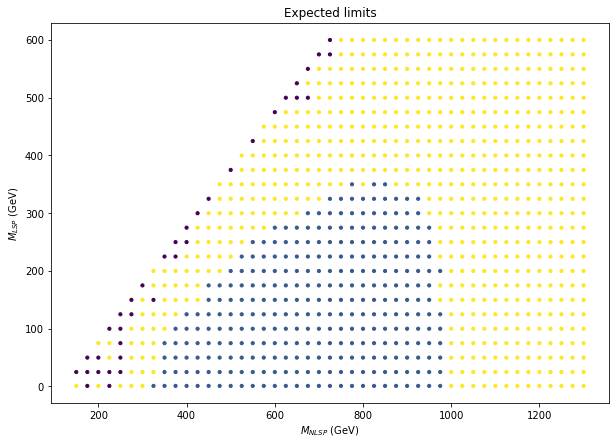

In [98]:
#plt.scatter(signal_df['mNLSP'].tolist(), signal_df['mLSP'], s=area, c=colors, alpha=0.5)

colors = (signal_df['expected']>0)*((signal_df['expected']>1)*0.9 + (signal_df['expected']<1)*0.25)

signal_df['mNLSP']

fig, ax = plt.subplots(1,1,figsize=(10,7))

plt.scatter(signal_df['mNLSP'], signal_df['mLSP'], s=10, c=colors, alpha=1)
plt.xlabel(r'$M_{NLSP}$ (GeV)')
plt.ylabel(r'$M_{LSP}$ (GeV)')
plt.title('Expected limits')

plt.show()

/home/users/dspitzba/miniconda3/envs/daskanalysisenv/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


Total number of events for signal point: 14.3271536634129
Total number of events for signal point: 5.202719501412503


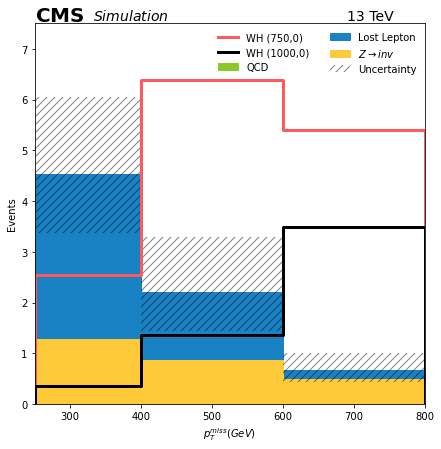

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finis

In [112]:
from plots.helpers import *

fig, ax = plt.subplots(1,1,figsize=(7,7))
hist.plot1d(background_met[notsignal],overlay="dataset", ax=ax, stack=True, overflow='over', clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['ZNuNu', 'LL', 'QCD'])
hist.plot1d(makeSignalHist(output["MET_pt"], mNLSP=750, mLSP=0), overlay="dataset", ax=ax, overflow='over', line_opts={'linewidth':3}, clear=False)
hist.plot1d(makeSignalHist(output["MET_pt"], mNLSP=1000, mLSP=0), overlay="dataset", ax=ax, overflow='over', line_opts={'linewidth':3}, clear=False)

ax.set_ylim(0,7.5)

saveFig(fig, ax, None, '/home/users/dspitzba/public_html/WH_had/', 'WH_SR', scale='linear', shape=False)


In [102]:
tmp_hist = makeSignalHist(output["MET_pt"], mNLSP=750, mLSP=0)

Total number of events for signal point: 14.3271536634129


In [109]:
tmp_hist['WH'].label

'Counts'

# Old shit that we should ignore

In [21]:
import pandas as pd

signal_xsec = [{'mNLSP': 750, 'mLSP': 1, 'sumweight':  68870.0, 'xsec': 6.69356}]

signal_df = pd.DataFrame(signal_xsec)

## this is probably worst practice ever
def getWeight(mNLSP_array, mLSP_array):
    weight = []
    for mNLSP, mLSP in zip(mNLSP_array, mLSP_array):
        try:
            tmp = float(signal_df[((signal_df['mNLSP']==mNLSP) & (signal_df['mLSP']==mLSP))])
        except TypeError:
            tmp = 0.
        
        weight.append(tmp)
    return weight


In [22]:
signal_df[((signal_df['mNLSP']==751.) & (signal_df['mLSP']==1.))]['xsec']

Series([], Name: xsec, dtype: float64)

In [99]:
import time

tstart = time.time()

getWeight(mNLSP, mLSP)

elapsed = time.time() - tstart

print (elapsed)

225.64772748947144


In [100]:
def test(x):
    return x**2

In [101]:
test(mNLSP)

array([ 250000.,  250000.,  250000., ..., 1050625., 1050625., 1050625.])

In [23]:
signal_df

,mNLSP,mLSP,sumweight,xsec
0,750,1,68870.0,6.69356


In [103]:
signal_df.lookupkup()

TypeError: lookup() missing 2 required positional arguments: 'row_labels' and 'col_labels'

In [24]:
test_df = pd.DataFrame({'mNLSP': mNLSP, 'mLSP': mLSP})

In [25]:
test_df

,mNLSP,mLSP
0,500.0,100.0
1,500.0,100.0
2,500.0,100.0
3,500.0,100.0
4,500.0,100.0
...,...,...
260167,1025.0,600.0
260168,1025.0,600.0
260169,1025.0,600.0
260170,1025.0,600.0


In [109]:
test_df.mLSP.map(signal_df['mLSP'])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
260167   NaN
260168   NaN
260169   NaN
260170   NaN
260171   NaN
Name: mLSP, Length: 260172, dtype: float64

In [ ]:
test_df.apply(lambda row: example_dict[row['category']], axis=1)

In [26]:
## example from https://stackoverflow.com/questions/47930052/pandas-vectorized-lookup-of-dictionary

example_dict = {
        "category1":{
                "field1": 0.0,
                "filed2": 5.0},
        "category2":{
                "field1": 5.0,
                "field2": 8.0}}

d = {"ids": range(10),
     "category": ["category1" if x % 2 == 0 else "category2" for x in range(10)]}

df = pd.DataFrame(d)
# The operation I am trying to vectorize


In [27]:
df

,ids,category
0,0,category1
1,1,category2
2,2,category1
3,3,category2
4,4,category1
5,5,category2
6,6,category1
7,7,category2
8,8,category1
9,9,category2


In [30]:
example_dict

{'category1': {'field1': 0.0, 'filed2': 5.0},
 'category2': {'field1': 5.0, 'field2': 8.0}}

In [28]:
df['category_data'] = df.apply(lambda row: example_dict[row['category']], axis=1)

In [29]:
df

,ids,category,category_data
0,0,category1,"{'field1': 0.0, 'filed2': 5.0}"
1,1,category2,"{'field1': 5.0, 'field2': 8.0}"
2,2,category1,"{'field1': 0.0, 'filed2': 5.0}"
3,3,category2,"{'field1': 5.0, 'field2': 8.0}"
4,4,category1,"{'field1': 0.0, 'filed2': 5.0}"
5,5,category2,"{'field1': 5.0, 'field2': 8.0}"
6,6,category1,"{'field1': 0.0, 'filed2': 5.0}"
7,7,category2,"{'field1': 5.0, 'field2': 8.0}"
8,8,category1,"{'field1': 0.0, 'filed2': 5.0}"
9,9,category2,"{'field1': 5.0, 'field2': 8.0}"


In [34]:
test_df.apply(lambda row: signal_df[((signal_df['mNLSP']==row['mNLSP'])&(signal_df['mLSP']==row['mLSP']))], axis=1)

0         Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
1         Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
2         Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
3         Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
4         Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
                                ...                        
260167    Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
260168    Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
260169    Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
260170    Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
260171    Empty DataFrame
Columns: [mNLSP, mLSP, sumweig...
Length: 260172, dtype: object

In [33]:
signal_xsec

[{'mNLSP': 750, 'mLSP': 1, 'sumweight': 68870.0, 'xsec': 6.69356}]

In [92]:
signal_df

KeyError: 0

In [168]:
len(goodfiles)

189